# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)
nsplits = 2

In [6]:
s, xiell_split, cov_split = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_dg_CCF_monopole_cov.npy', allow_pickle=True)
std_split = np.array_split(np.array(np.array_split(np.diag(cov_split)**0.5, nells)), nsplits, axis=1)

### DS2 only

In [7]:
split = 1

xiell = xiell_split[split]
cov = extract_subcovmatrix(s, cov_split, ells, nsplits, split_extract=split)
std = np.array_split(np.diag(cov)**0.5, nells)

In [8]:
mocks_results = np.load(output_dir+catalog.name+'_1000_mocks_2PCF.npy', allow_pickle=True)
ells = [0]
nells = len(ells)

xiell, cov = get_poles(mocks_results, ells)
std = np.array_split(np.diag(cov)**0.5, nells)

## Set power spectrum model

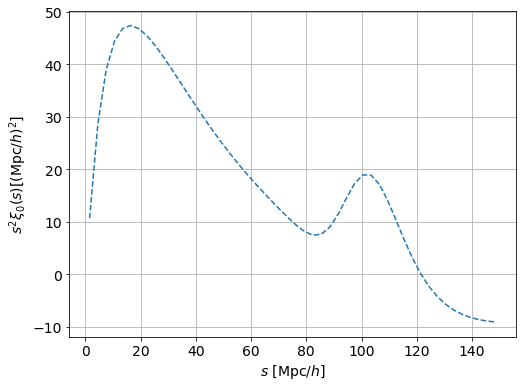

In [9]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
default_params = {'f': 0., 'b': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 0.}
pk_model.set_default_params(**default_params)
pk_model.plot_model()

## Fit model to data

In [10]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b': 2., 'alpha_par': 1., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

pk_model.fit(fit_params_init=params_init, s_lower_limit=s_lower_limit)

if hasattr(pk_model, 'broadband_coeffs'):
    model = pk_model.model(pk_model_params=pk_model.model_popt_dict, broadband_coeffs=pk_model.broadband_coeffs)
else:
    model = pk_model.model(pk_model_params=pk_model.model_popt_dict)

Optimal parameters:
{'b': 1.8018972836413507, 'alpha_par': 1.007775120462425, 'sigma_par': 4.832409291723025, 'broadband_coeffs': array([ 3.21168765e-02,  5.97615811e-03, -4.75640531e-05])}

Covariance matrix:
[[ 4.31143727e-02  9.13088386e-04  2.81669622e-01 -2.10977478e+00
   2.61543712e-02 -7.05013836e-05]
 [ 9.13088386e-04  1.05252662e-03  8.15840494e-03 -1.82156183e-02
   5.45331037e-04 -2.49765425e-06]
 [ 2.81669622e-01  8.15840494e-03  3.32593271e+00 -1.35812631e+01
   1.66197200e-01 -4.25737761e-04]
 [-2.10977478e+00 -1.82156183e-02 -1.35812631e+01  1.84190704e+02
  -3.30731721e+00  1.39129005e-02]
 [ 2.61543712e-02  5.45331037e-04  1.66197200e-01 -3.30731721e+00
   7.09980720e-02 -3.39261527e-04]
 [-7.05013836e-05 -2.49765425e-06 -4.25737761e-04  1.39129005e-02
  -3.39261527e-04  1.78806863e-06]]

Sigmas:
[2.07640007e-01 3.24426667e-02 1.82371399e+00 1.35716876e+01
 2.66454634e-01 1.33718683e-03]


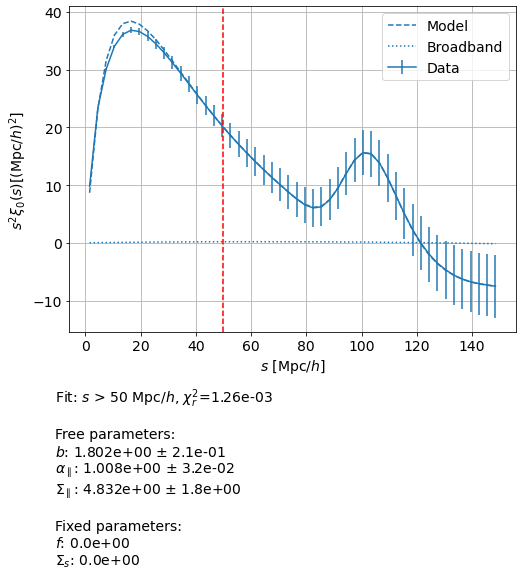

In [11]:
pk_model.plot_model(plot_data=True, show_info=True, show_broadband=True)
plt.show()

### Plot reduced $\chi^2$ as a function of a given parameter ($\alpha_{iso}$ or $\Sigma_{iso}$)

In [19]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

3


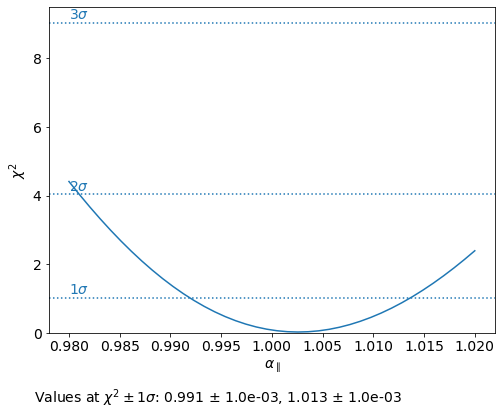

In [20]:
alphas = np.linspace(0.98, 1.02, 40)
free_params_init = {'b': 2., 'sigma_par': 5., 'broadband_coeffs': broadband_coeffs}

alpha_chi2_bao_peak = plot_likelihood(pk_model, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

/feynman/work/dphp/adematti/cosmodesiconda/20220419-1.0.0/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


3


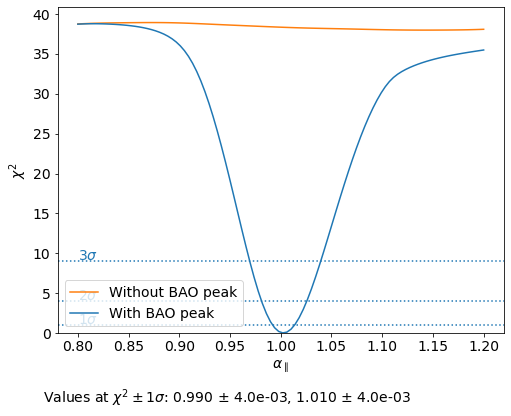

In [14]:
alpha_chi2_bao_peak = plot_likelihood(pk_model, param_name='alpha_par', param_values=alphas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=True)

In [15]:
pk_model = PkModel(sep=s, ells=ells, xiell=xiell, cov=cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=False)
pk_model.set_pk_model()
pk_model.set_default_params(**default_params)

1


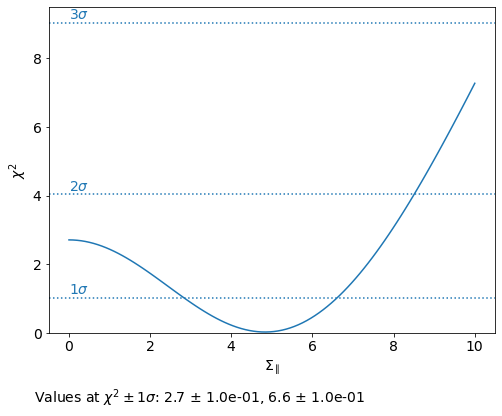

In [16]:
sigmas = np.linspace(0, 10, 100)
free_params_init = {'b': 2., 'alpha_par': 1., 'broadband_coeffs': broadband_coeffs}

sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=False)

1


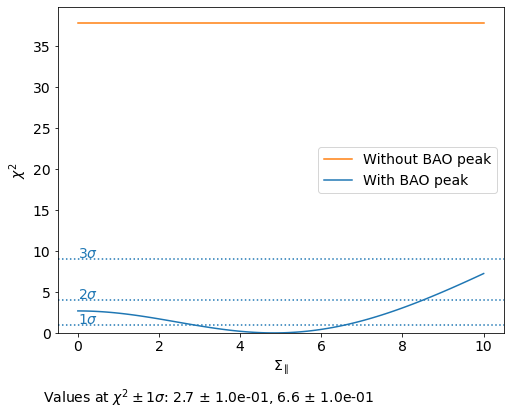

In [18]:
sigma_chi2_bao_peak = plot_likelihood(pk_model, param_name='sigma_par', param_values=sigmas, free_params_init=free_params_init, s_lower_limit=s_lower_limit, without_peak=True)